<a href="https://colab.research.google.com/github/SizhuangHe/FL-REU/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
import enum

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary

# Check assigned GPU
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#torch.set_printoptions(sci_mode=False)

# Some Hyperparameters

In [2]:
class WEIGHT_MODE(enum.Enum):
  SIMPLE_FEDAVG =  "fedavg"
  SIMPLE_ADJUST =  "simple_adjust"
  SIZE_OVER_EXP_VAL_LOSS =  "size_over_val_loss"

class VALIDATE_ON(enum.Enum):
  LOSS = "loss"
  ACCURACY = "accuracy"

In [3]:
input_size = 784
num_hidden_neuron = 200
num_classes = 10
output_size = num_classes
criterion = nn.CrossEntropyLoss()
classes_test = [i for i in range(num_classes)]

print("---------------------------Hyperparameters-------------------------------")
print(f"input size: {input_size}")
print(f"number of hidden neurons: {num_hidden_neuron}")
print(f"number of classes: {num_classes}")
print("-------------------------------------------------------------------------")


---------------------------Hyperparameters-------------------------------
input size: 784
number of hidden neurons: 200
number of classes: 10
-------------------------------------------------------------------------


# Models

In [4]:
class IRIS_NN(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, output_size):
    super(IRIS_NN, self).__init__()

    self.l1 = nn.Linear(input_size, num_hidden_neurons)
    self.l2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.l3 = nn.Linear(num_hidden_neurons, output_size)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    out = self.l3(x)
    return out

# Load DataSet

### Dataset setup

In [5]:
# df = pd.read_csv("Iris.csv")

# le=LabelEncoder()
# df['Species']=le.fit_transform(df['Species'])

# label=df['Species'].values

# scaler=StandardScaler()
# df = df.drop('Species',axis=1)
# df = df.drop('Id', axis=1)
# scaled_df=scaler.fit_transform(df)

# feature=scaled_df.astype(np.float32)

In [6]:
class IrisData(Dataset):
  def __init__(self, feature, label):
    self.feature = feature
    self.label = label

  def __len__(self):
    return len(self.label) 

  def __getitem__(self, idx):
    sample = self.feature[idx]
    return sample, self.label[idx]   

### Transform (Add Gaussian Noise)

In [7]:
def add_gaussian_noise(dataset, client_dict, client, mean, std):
  """
  This function add Gaussian noise to local dataset of a client.

  Params:
    - dataset (torch.utils.Dataset): the training dataset
    - client_dict (dictionary): dictionary of clients, should be the one before training-validation split
          since we are simulating a corrupted client here
    - client (int): the client to add noise to
    - mean (float): mean of random noise
    - std (float): standard deviation of random noise      

  Returns:
    Nothing. But modifies the local dataset of the specified client.
  """


  # for data, label in CustomDataset(dataset, client_dict[client]):
  #   # rand_noise = (torch.randn(len(data)) * std + mean).numpy()
  #   
  #   data += rand_noise
  
  for set_item in client_dict[client]:
    pic_idx = set_item
    data = dataset.data[pic_idx]
    data = data.numpy()
    randn_noise = torch.ones(data.shape)*torch.randn(1).item()*std + torch.ones(data.shape)*mean
    data = randn_noise + data
    dataset.data[pic_idx] = data

  print(f"Gaussian Noise with mean {mean} and standard deviation {std} is added to client {client}.")  

In [8]:
def add_relative_gaussian_noise(dataset, client_dict, client, relative_std):
  """
  This function adds Gaussian noise to a specified client. The difference bewteen
  this function and the add_gaussian_noise function is that the user pass a relative_std,
  which is a double between 0 and 1 to this function and then noise will be generated
  with mean 0 and std (relative_std * mean of this client's local dataset).

  Params:
    - dataset (torch.utils.dataset): the training set
    - client_dict (dictionary): client dictionary before train-val split
    - relative_std (double): a double in [0,1]

  Returns:
    Nothing. But modifies parts of the dataset.
  """
  loader =  DataLoader(CustomDataset(dataset_train, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
  data, label = iter(loader).next()
  data_np = data.numpy()
  client_mean = np.mean(data_np)
  std = relative_std * client_mean

  for feature, label in CustomDataset(dataset, client_dict[client]):
    rand_noise = (torch.randn(len(feature)) * std + mean).numpy()
    feature += rand_noise


In [9]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, sample):
#       sample += (torch.randn(sample.size) * self.std + self.mean).numpy()
#       return sample
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


### Other built-in dataset

#### Tabular datasets

##### sklearn Boston dataset (Regression)

In [10]:
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# feature = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]).astype(np.float32)
# label = raw_df.values[1::2, 2].astype(np.float32)

# scaler=StandardScaler()
# feature = scaler.fit_transform(feature)

#### Image datasets

##### MNIST

In [37]:
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

dataset_train1 = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)
dataset_train2 = copy.deepcopy(dataset_train1)
dataset_train3 = copy.deepcopy(dataset_train1)

##### CIFAR


In [12]:


# dataset_train1 = datasets.CIFAR10('./data/cifar/', train=True, download=True, transform=transforms.ToTensor())
# datset_train2 = copy.deepcopy(dataset_train1)
# datset_train3 = copy.deepcopy(dataset_train1)
# dataset_test = datasets.CIFAR10('./data/cifar/', train=False, download=True, transform=transforms.ToTensor())

### Data preparation

Prepare the entire dataset to be two np arrays, one named feature and one named label. Then the following does not need changing.

In [13]:
# feature_train,feature_test,label_train, label_test=train_test_split(feature, label, test_size=0.40,random_state=42)

In [14]:
# dataset_train1 = IrisData(feature_train, label_train) # only the __init__ function is called here
# datset_train2 = copy.deepcopy(dataset_train1)
# datset_train3 = copy.deepcopy(dataset_train1)
# dataset_test = IrisData(feature_test, label_test)

# Partition the Data

In [15]:
# dataset here is passed in but only its length is actually used. Can be optimized if necessary.

def iid_partition(dataset, num_clients, report_iid_metric=False):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - num_clients (int): Number of Clients to split the data between

  returns:
    - client_dict(dictionary): a dictionary of indices for each client
      -> dictionaries are made up of (key, value) pairs
        -> each key in client_dict is an int representing a client
        -> each value is a Python set of int's, where each int is an index of data in the dataset     
  """

  num_items_per_client = int(len(dataset)/num_clients)
  client_dict = {}
  idxs = [i for i in range(len(dataset))]

  for i in range(num_clients):
    client_dict[i] = set(np.random.choice(idxs, num_items_per_client, replace=False))
    idxs = list(set(idxs) - client_dict[i])

  if report_iid_metric == True:
    report_client_mean_variance(client_dict, dataset)
    
  return client_dict

In [39]:
def non_iid_partition(dataset, num_clients, num_shards, report_iid_metric=False):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Randomly assign each client with  shards

  Params:
    - dataset (torch.utils.Dataset): the training dataset
    - num_clients (int): Number of Clients to split the data between
    - num_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives
      -> dictionaries are made up of (key, value) pairs
        -> each key in client_dict is an int representing a client
        -> each value is a Python set of int's, where each int is an index of data in the dataset     
  

  Returns:
    - client_dict_out (dictionary): a dictionary of indices for each client
  """
  
  dataset_len = len(dataset)
  shards_size = dataset_len//num_shards # floor division
  num_shards_per_client = num_shards//num_clients
  
  shard_idxs = [i for i in range(num_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(num_clients)}
  client_dict_out = {}
  idxs = np.arange(dataset_len)
  #print(f"idxs: {idxs}")
  
  #data_labels = dataset.label # data_labels should be a np array of all labels
  data_labels = dataset.targets.numpy()
  #print(f"data_labels: {data_labels}")

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels)) # put idxs and data_labels as a 2D np array
  #print(f"label_idx: {label_idxs}")
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  #print(f"label_idx new: {label_idxs}")
  idxs = label_idxs[0,:].astype(int) # only want the idxs layer of the sorted 2D array 
  #print(f"idxs new: {idxs}")

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(num_clients):
    selected_shards_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    #print(f"rand_set: {rand_set}")
    shard_idxs = list(set(shard_idxs) - selected_shards_set)
    #print(f"shard_idxs: {shard_idxs}")

    for shard in selected_shards_set:
      #print(f"to append: {idxs[rand*shards_size:(rand+1)*shards_size]}")
      client_dict[i] = np.concatenate((client_dict[i], idxs[shard * shards_size : (shard+1)*shards_size]))
      set_i = set(client_dict[i])
      client_dict_out[i] = set_i

  if report_iid_metric == True:
    report_client_mean_variance(client_dict_out, dataset)  

  return client_dict_out

In [17]:
def client_dict_train_val_split(client_dict_in, validation_ratio):
  """
  Split each client data randomly to two parts: training data and validation data

  Params:
    - client_dict_in (python dictionary): the client dictionary
    - validation_ratio (double): the proportion of client data to be spitted into validation data

  Returns:
    - client_dict_out (dictionary): dictionary of indices for each client's training and validation data  
      -> client_dict_out is a nested dictionary
        -> each key,value pair looks like this
          -> key (int) representing the client, value (dictionary): {"train": a set of int's , "validation": a set of int's}
  """
  client_dict_out = {}


  for client in client_dict_in:
    num_total_data = len(client_dict_in[client])
    num_val_data = int(num_total_data * validation_ratio)
    val_set = set(np.random.choice(np.array(list(client_dict_in[client])), num_val_data, replace=False))
    train_set = client_dict_in[client] - val_set
    client_dict_out[client]={}
    client_dict_out[client]["train"] = train_set
    client_dict_out[client]["validation"] = val_set
    
  return client_dict_out  

In [18]:
# Not sure if to account client dataset size
def report_client_mean_variance(client_dict, dataset):
  """
  This function returns the mean of each client's local training set
  Can use this to roughly see how iid the dictionary is

  Note: the client_dict passes in should be the one before train-val split
  """
  mean = []

  for client in client_dict:
    loader =  DataLoader(CustomDataset(dataset, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
    ld = iter(loader).next()
    data, label = ld
    label_np = label.numpy()
    label_mean = np.mean(label_np)
    for i in range(len(client_dict[client])): # for label_mean of a certain client, append it for multiple times = size of this client's local dataset
      mean.append(label_mean)

  print("-> Variance of mean client data: ", np.var(mean))
  print("-> Note: a small value is expected for i.i.d partition and a large value typically indicate the partition is non-iid.")

# Client Training


In [19]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs_set):

      self.dataset = dataset
      self.idxs = list(idxs_set)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      feature, label = self.dataset[self.idxs[item]]
      return feature, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, client_set, criterion, num_classes,isClassification):
    self.train_loader = DataLoader(CustomDataset(dataset, client_set["train"]), batch_size=batchSize, shuffle=True)
    self.dataset = dataset
    self.idx_set = client_set["validation"]
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.criterion = criterion
    self.num_classes = num_classes
    self.isClassification = isClassification

  def train(self, model):

    """
    This function performs local training

    Params:
      - model: the global model that the server sends to each client in the current global training round

    Returns:
      - model.state_dict():   a dictionary of all model parameters of the trained local model
      - total_loss:           the average training loss of the trained local model
      - val_loss:             the validation loss 
    """

    criterion = self.criterion
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []

    

    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss

        # length = len(labels)
        # labels = labels.view((length,1)) # to make dimensions right, needed when doing regression

        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    # validation
    model.eval()
    val_loss, val_accuracy, val_accuracy_str = local_validate(model=model, dataset=self.dataset, idx_set=self.idx_set, criterion=criterion, num_classes= self.num_classes,isClassification= self.isClassification)


    return model.state_dict(), total_loss, val_loss, val_accuracy, val_accuracy_str

# Server Training

## Weights Functions

In [20]:
def size_of_clients(client_dict, active_client):
  """
  This function returns the sizes of each clients.

  Params:
    - client_dict (dictionary): a dictionary of clients
    - active_clients (array): each element is an active client, used as a key to search in client_dict

  Returns:
    - client_sizes (array): each element corresponds to the size of local dataset of clients in active_client, Note: the order should match with active_clients  
  """

  client_sizes = []
  for ac in range(len(active_client)):
    size = len(client_dict[active_client[ac]]["train"])
    client_sizes.append(size)

  return client_sizes  

### calc_weights
### This class of functions calculate weights of different local models based on different formulae.

In [21]:
def calc_weights_simple_adjust_loss(client_sizes, val_losses):
  """
  The weight of a certain client is its size/val_loss and then normalize the weight vector to a sum of 1.

  Params:
    - client_sizes (array): an array of sizes of each client's local dataset
    - val_losses (array): an array of validation losses of each client's local model

  Returns:
    - weights_of_models (array): an array of computed weights of each cient model 
  """
  weights_of_models = []

  for i in range(len(client_sizes)):
    weights_of_models.append(client_sizes[i] / (val_losses[i]+0.0001)) # +0.0001 to prevent dividing by 0

  total_weights = np.sum(weights_of_models)
  weights_of_models = weights_of_models / total_weights 

  return weights_of_models

In [22]:
def calc_weights_simple_adjust_accuracy(client_sizes, val_accuracies):
  """
  The weight of a certain client is its size*val_accuracy and then normalize the weight vector to a sum of 1.

  Params:
    - client_sizes (array): an array of sizes of each client's local dataset
    - val_losses (array): an array of validation losses of each client's local model

  Returns:
    - weights_of_models (array): an array of computed weights of each cient model 
  """
  weights_of_models = []

  for i in range(len(client_sizes)):
    weights_of_models.append(client_sizes[i] * val_accuracies[i])
  
  total_weights = np.sum(weights_of_models)
  weights_of_models = weights_of_models / total_weights 

  return weights_of_models

In [23]:
def calc_weights_fedavg(client_sizes):
  """
  This is the original FedAvg. The weight of one certain client is size/total_size.
  
  Params:
    - client_sizes (array): an array of sizes of each client's local dataset
    - val_losses (array): an array of validation losses of each client's local model

  Returns:
    - weights_of_models (array): an array of computed weights of each cient model 
  """
  total_size = np.sum(client_sizes)
  weights_of_models = client_sizes/total_size

  return weights_of_models

In [24]:
# def calc_weights(client_sizes, val_losses):
#   weights_of_models = []

#   for i in range(len(client_sizes)):
#     weights_of_models.append(client_sizes[i] / np.exp(val_losses[i]))

#   total_weights = np.sum(weights_of_models)
#   weights_of_models = weights_of_models / total_weights 
#   return weights_of_models

In [25]:
# def calc_weights(client_sizes, val_losses):
#   weights_of_models = []

#   for i in range(len(client_sizes)):
#     weights_of_models.append(client_sizes[i] + 1/val_losses[i])

#   total_weights = np.sum(weights_of_models)
#   weights_of_models = weights_of_models / total_weights 
#   return weights_of_models

## Training

In [26]:
def training(model, num_rounds, batch_size, num_classes, learning_rate, dataset, data_dict, active_client_fraction, num_clients, num_epochs, criterion, weight_mode, validate_on,plt_title, isClassification,plt_color, verbose=True):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:                    PyTorch model to train
    - num_rounds:               Number of global training rounds (also, communication rounds)
    - batch_size:               Batch size for client update training
    - learning_rate:            Learning rate used for client update training
    - dataset:                  Dataset used for training
    - data_dict:                Type of data partition used for training (IID or non-IID)
    - active_client_fraction:   Fraction of clients randomly chosen to perform computation on each round
    - num_clients:              Total number of clients
    - num_epochs:               Number of training passes each client makes over its local dataset per round
    - criterion:                Loss function to use
    - weight_mode (enum):       Mode of computing weights of different local models
    - validate_on (enum):       Adjust the weight based on validation loss or accuracy
                                Note: 
                                      1. if weight_mode is set to WEIGHT_MODE.SIMPLE_FEDAVG,
                                       validate_on will make no difference 
                                      2. if isClassification is set to False,
                                       that is we are dealing with a regression problem,
                                       validate_on will be automatically overwritten to
                                       VALIDATE_ON.LOSS and will print a message

    - isClassification:         Whether or not is this a classification
    - tb_writer_name:           Directory name to save the tensorboard logs
  
  Returns:
    - model:                    Trained model on the server
  """

  if isClassification == False and validate_on == VALIDATE_ON.ACCURACY:
    print("---> Validation on accuracy for regression problems is not allowed. Automatically set to validate on loss.")
    validate_on = VALIDATE_ON.LOSS

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  
  # measure time
  start = time.time()
  if verbose == True:
    print("------------------------Training Mode Summary----------------------------")
    if weight_mode == WEIGHT_MODE.SIMPLE_FEDAVG:
      print("---> Weight mode: FedAvg.")
      print("---> Validation mode: No validation for FedAvg.")
    else:
      print("---> Weight mode: adjustment.")
      print(f"---> Validation mode: Validation will be based on validation {validate_on.value}.")   

    if isClassification == True:
      print("---> Task type: Classification")
    else:
      print("---> Task type: Regression")  
    print("-------------------------------------------------------------------------")


  for curr_round in range(1, num_rounds+1):
    w, local_loss, val_loss, val_accuracy, val_accuracy_str = [], [], [], [], []

    num_active_client = max(int(active_client_fraction*num_clients), 1)
    
    active_clients = np.random.choice(range(num_clients), num_active_client, replace=False) # active_clients is the array of clients to train on
    active_clients.sort() # to make it easy to look at the printed summaries

    client_sizes = size_of_clients(client_dict=data_dict, active_client=active_clients)
    
    for k in active_clients:
      local_update = ClientUpdate(dataset=dataset, batchSize=batch_size, learning_rate=learning_rate, epochs=num_epochs, client_set=data_dict[k], criterion=criterion, num_classes=num_classes,isClassification=isClassification) # initialize the local update object
      weights, loss, local_val_loss, local_val_accuracy, local_val_accuracy_str = local_update.train(model=copy.deepcopy(model))

      val_loss.append(local_val_loss)
      val_accuracy.append(local_val_accuracy)
      val_accuracy_str.append(local_val_accuracy_str)
      w.append(copy.deepcopy(weights))
      local_loss.append(loss*client_sizes[k])


    # updating the global weights
    if weight_mode == WEIGHT_MODE.SIMPLE_ADJUST:
      if validate_on == VALIDATE_ON.LOSS:
        weights_of_models = calc_weights_simple_adjust_loss(client_sizes=client_sizes, val_losses=val_loss)
      else:
        weights_of_models = calc_weights_simple_adjust_accuracy(client_sizes=client_sizes, val_accuracies= val_accuracy)
    else:
      weights_of_models = calc_weights_fedavg(client_sizes=client_sizes)

    # print(len(val_loss))
    # print(len(client_sizes))
    # print(len(weights_of_models))
    # print(len(w))

    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      weights_avg[k] = torch.mul(weights_avg[k], weights_of_models[0]) 
      for i in range(1, len(weights_of_models)): 
        # index i here corresponds to each local model and index k here corresponds to each model weight 
        weights_avg[k] += w[i][k] * weights_of_models[i]

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / sum(client_sizes) 
    train_loss.append(loss_avg)

    if verbose == True:
      print("----------------------------Round Summary--------------------------------")
      print(f"---> Round: {curr_round}, Average training loss: {loss_avg}")
      print(f"---> Active Clients: {active_clients}")
      print(f"---> Client Training Set Sizes: {client_sizes}")
      print(f"---> Validation losses: {val_loss}")
      if isClassification == False:
        print("Regression problem. Validation accuracy is not applicable.")
      else:
        print(f"---> Validation accuracy: {val_accuracy}")  
        print(f"     Validation result: {val_accuracy_str}")
        print(f"---> Weights of Local Models: {weights_of_models}")
      print("-------------------------------------------------------------------------")

    

  end = time.time()

  fig_train, ax_train = plt.subplots()
  x_axis_train = np.arange(1, rounds+1)
  y_axis_train = np.array(train_loss)
  ax_train.plot(x_axis_train, y_axis_train, 'tab:'+plt_color)

  ax_train.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax_train.grid()
  fig_train.savefig(plt_title+'.jpg', format='jpg')

  # fig_val, ax_val = plt.subplots()
  # x_axis_val = np.arange(1, rounds+1)
  # y_axis_val = np.array(val_loss)
  # ax_val.plot(x_axis_val, y_axis_val, 'tab:'+plt_color)

  # ax_val.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title=plt_title)
  # ax_val.grid()
  # fig_val.savefig(plt_title+'.jpg', format='jpg')

  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

# Validation

In [27]:
def local_validate(model, dataset, idx_set, criterion, num_classes, isClassification):
  """
  This function will do a validation of the model on a given dataset.

  Param:
    - model (torch.nn): the already trained Pytorch model to validate
    - dataset (torch.utils.Dataset): the dataset to load data from
    - idx_set (set): a set of integers, corresponding to the index of data to validate on
    - criterion: the loss function to use
    - isClassification (boolean): True if this is a classification problem and
      this function will calculate the validation accuracy

  Returns:
    - val_loss (float): the loss of the model on this validation set  
    - val_accuracy (float): for regression problems, return a dummy -1
  """

  val_loss = 0.0
  val_accuracy = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))
  
  val_loader = DataLoader(CustomDataset(dataset, idx_set), batch_size=len(idx_set), shuffle=True)

  for data, labels in val_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    
    # length = len(labels)
    # labels = labels.view((length,1)) # to make dimensions right, only needed in regression
    
    # compute validation loss
    loss = criterion(output, labels) 
    val_loss += loss.item()*data.size(0)  

    # compute validation accuracy for classification problems 
    if isClassification == True:
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      # print(f"---> Debug: label: {labels}")
      # print(f"---> Debug: pred:  {pred}")
      # print(f"---> Debug: correct:{correct_tensor}")
      for i in range(len(data)):
        label = labels.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1


  num_correct_label = np.sum(correct_class)
  num_total_label = np.sum(total_class)
  if isClassification == True:
    val_accuracy = num_correct_label / num_total_label
  else:
    val_accuracy = -1  
  
  val_loss = val_loss/len(val_loader.dataset)

  num_correct_label_str = str(num_correct_label)
  num_total_label_str = str(num_total_label)
  val_accuracy_string = num_correct_label_str + "/" + num_total_label_str
  
  return val_loss, val_accuracy, val_accuracy_string

In [28]:
def gobal_validate(model, dataset, val_idx, criterion,num_classes, classes, report_accuracy):
  batch_size = len(val_idx)
  val_loader = DataLoader(CustomDataset(dataset, val_idx), batch_size=len(val_idx), shuffle=True)
  return test(model, dataset, batch_size, criterion, num_classes, classes, val_loader, "Validation", report_accuracy=report_accuracy)

# Test

In [29]:
def test(model, dataset, bs, criterion, num_classes, classes, loader, mode, report_accuracy):
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  for data, labels in loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)

    # length = len(labels)
    # labels = labels.view((length,1)) # to make dimensions right, only needed in regression

    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    if report_accuracy == True:
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      #print(f"data len: {len(data)}")
      #test accuracy for each object class
      for i in range(len(data)):
        label = labels.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1
        #print(f"i: {i}, label: {label}")
   
    
  # avg test loss
  test_loss = test_loss/len(loader.dataset)
  
  print(mode, "Loss: {:.6f}\n".format(test_loss))

  if report_accuracy == True:
    # print test accuracy
    for i in range(num_classes):
      if total_class[i]>0:
        print(mode, 'Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i]))) 

      else:
        print(mode, 'Accuracy of %5s: N/A (no '% (classes[i]), mode, ' examples)' )
      
    print('\nFinal ', mode, ' Accuracy: {:.3f} ({}/{})\n'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

  return test_loss

In [30]:
def testing(model, dataset, bs, criterion, num_classes, classes, report_accuracy):
  test_loader = DataLoader(dataset, batch_size=bs)
  
  model.eval()
  test(model, dataset, bs, criterion, num_classes, classes, test_loader, "Test", report_accuracy=report_accuracy)

# Debugging Functions

In [31]:
def seeClientData(dataset, client_dict, client):
  """
  Use this function to see the specific data a client holds

  Params:
    - dataset (torch.utils.dataset): the training dataset
    - client_dict (dictionary): the dictionary of clients, NOTE: after train-val split
    - client (int): the client you want to inspect

  Returns:
    - Nothing. Print client data.  
  """

  train_loader = DataLoader(CustomDataset(dataset, client_dict[client]["train"]), batch_size=len(client_dict[client]["train"]), shuffle=False)
  tld = iter(train_loader).next()
  train_data, train_label = tld
  print(f"-> Training set size of client {client}: {len(train_data)}")
  print(f"-> Training data of client {client}: {train_data}")
  print(f"-> Corresponding label: {train_label}")

  val_loader = DataLoader(CustomDataset(dataset, client_dict[client]["validation"]), batch_size=len(client_dict[client]["validation"]), shuffle=False)
  vld = iter(val_loader).next()
  val_data, val_label = vld
  print(f"-> Validation set size of client {client}: {len(val_data)}")
  print(f"-> Validation data of client {client}: {val_data}")
  print(f"-> Corresponding label: {val_label}")


In [32]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

def visualize(dataset, client_dict, client):
  figure1 = plt.figure(figsize=(25,4))
  
  num_pic_shown = 0

  print("Training set images:")
  for set_item in client_dict[client]["train"]:
    axis1 = figure1.add_subplot(2, 10, num_pic_shown+1, xticks=[], yticks=[])
    pic_idx = set_item
    data = dataset.data[pic_idx]
    data = data.numpy()
    target = dataset.targets[pic_idx]
    target = target.numpy()
    imshow(data)
    axis1.set_title(target)
    num_pic_shown += 1
    # print(data)
    if num_pic_shown >=5:
      break
  
  figure2 = plt.figure(figsize=(25,4))
  num_pic_shown = 0
  print("Validation set images:")
  for set_item in client_dict[client]["validation"]:
    axis2 = figure2.add_subplot(2, 10, num_pic_shown+1, xticks=[], yticks=[])
    pic_idx = set_item
    data = dataset.data[pic_idx]
    data = data.numpy()
    target = dataset.targets[pic_idx]
    target = target.numpy()
    imshow(data)
    axis2.set_title(target)
    num_pic_shown += 1
    if num_pic_shown >=5:
      break






# IID Case

## Experiment Setup

In [33]:
# number of training rounds
rounds = 150
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = iid_partition(dataset=dataset_train1, num_clients=K, report_iid_metric=True)

iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)

# loader =  DataLoader(CustomDataset(dataset_train, client_dict[0]), batch_size=len( client_dict[0]), shuffle=True)
# ld = iter(loader).next()
# data, label = ld
# print("data: ", data, "label: ", label)

# initialize model


-> Variance of mean client data:  0.0030307566666666627
-> Note: a small value is expected for i.i.d partition and a large value typically indicate the partition is non-iid.


Training set images:
Validation set images:


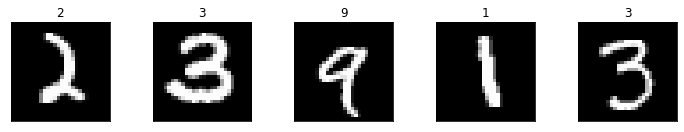

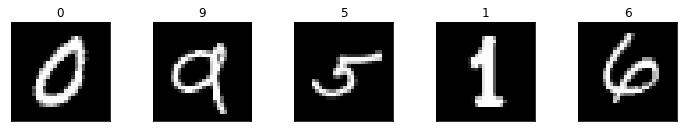

In [34]:
#seeClientData(dataset=dataset_train1, client_dict=iid_dict, client=0)
visualize(dataset_train1, iid_dict, 0)

In [50]:
val_mode1 = VALIDATE_ON.ACCURACY
weight_mode1 = WEIGHT_MODE.SIMPLE_FEDAVG
val_mode2 = VALIDATE_ON.LOSS
weight_mode2 = WEIGHT_MODE.SIMPLE_ADJUST
val_mode3 = VALIDATE_ON.ACCURACY
weight_mode3 = WEIGHT_MODE.SIMPLE_ADJUST


In [42]:
print("-----------------------------Experiment Setup-----------------------------")
print("Client Partition: IID")
print(f"Number of communication rounds: {rounds}")
print(f"Fraction of active clients: {C}")
print(f"Number of total clients: {K}")
print(f"Number of local epochs: {E}")
print("--------------------------------------------------------------------------")

-----------------------------Experiment Setup-----------------------------
Client Partition: IID
Number of communication rounds: 150
Fraction of active clients: 1
Number of total clients: 10
Number of local epochs: 10
--------------------------------------------------------------------------


## Experiments

### Experiment 1
without noise, without adjustment, pure FedAvg

In [ ]:
model_iid1 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid1.cuda()

model_iid_trained1 = training(model=model_iid1, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode1, validate_on=val_mode1, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained1, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 2: 
without noise, with adjustment, validating on loss

In [ ]:
model_iid2 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid2.cuda()

model_iid_trained2 = training(model=model_iid2, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode2, validate_on=val_mode2, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained2, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 3
without noise, with adjustment, validating on accuracy

In [ ]:
model_iid3 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid3.cuda()

model_iid_trained3 = training(model=model_iid3, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode3, validate_on=val_mode3, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained3, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Add noise to client 0

Gaussian Noise with mean 1000 and standard deviation 500000 is added to client 0.
Training set images:
Validation set images:


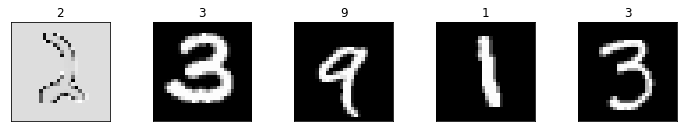

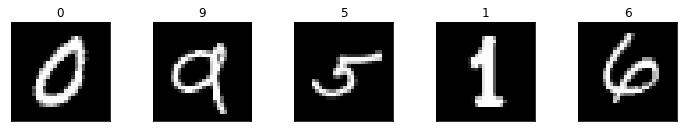

In [44]:
mean=1000
std=500000
add_gaussian_noise(dataset=dataset_train1, client_dict=client_dict, client=0, mean=mean, std=std)
#seeClientData(dataset=dataset_train1, client_dict=iid_dict, client=0)
visualize(dataset_train1, iid_dict, 0)

### Experiment4
with noise (mean = 0, std = 50), without adjustment

In [ ]:
model_iid4 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid4.cuda()

model_iid_trained4 = training(model=model_iid4, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode1, validate_on=val_mode1, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained4, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 5
with noise (mean = 0, std = 50), with adjustment, validating on loss


In [ ]:
model_iid5 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid5.cuda()

model_iid_trained5 = training(model=model_iid5, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode2, validate_on=val_mode2, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained5, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 6
 with noise (mean = 0, std = 50), with adjustment, validating on accuracy

In [ ]:
model_iid6 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_iid6.cuda()

model_iid_trained6 = training(model=model_iid6, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train1, data_dict=iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode3, validate_on=val_mode3, plt_title="on IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_iid_trained6, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

# Non IID training

## Training Setup

In [40]:
# number of training rounds
rounds = 150
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = non_iid_partition(dataset_train2, num_clients=K, num_shards=K, report_iid_metric=True) # every client is given only one shard, which is very non_iid 
non_iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)
#seeClientData(dataset=dataset_train2, client_dict=non_iid_dict, client=0)

# seeClientData(dataset=dataset_train, client_dict=non_iid_dict, client=0)
# seeClientData(dataset=dataset_train, client_dict=non_iid_dict, client=1)
# seeClientData(dataset=dataset_train, client_dict=non_iid_dict, client=2)


# loader =  DataLoader(CustomDataset(dataset_train, client_dict[0]), batch_size=len( client_dict[0]), shuffle=True)
# ld = iter(loader).next()
# data, label = ld
# print("data: ", data, "label: ", label)


-> Variance of mean client data:  8.301958195555557
-> Note: a small value is expected for i.i.d partition and a large value typically indicate the partition is non-iid.
-> Training set size of client 0: 4800
-> Training data of client 0: tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

Training set images:
Validation set images:


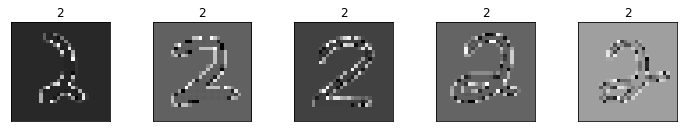

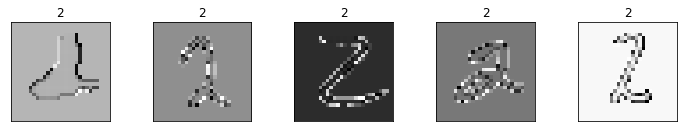

In [48]:
visualize(dataset_train2, non_iid_dict, 0)

In [ ]:
print("-----------------------------Experiment Setup-----------------------------")
print("Client Partition: non-IID")
print(f"Number of communication rounds: {rounds}")
print(f"Fraction of active clients: {C}")
print(f"Number of total clients: {K}")
print(f"Number of local epochs: {E}")
print("--------------------------------------------------------------------------")

## Experiments

### Experiment 1
without noise, without adjustment, pure FedAvg

In [ ]:
model_non_iid1 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid1.cuda()

model_non_iid_trained1 = training(model=model_non_iid1, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode1, validate_on=val_mode1, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained1, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 2: 
without noise, with adjustment, validating on loss

In [ ]:
model_non_iid2 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid2.cuda()

model_non_iid_trained2 = training(model=model_non_iid2, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode2, validate_on=val_mode2, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained2, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 3
without noise, with adjustment, validating on accuracy

In [ ]:
model_non_iid3 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid3.cuda()

model_non_iid_trained3 = training(model=model_non_iid3, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode3, validate_on=val_mode3, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained3, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Add noise to client 0

Gaussian Noise with mean 1000 and standard deviation 500000 is added to client 0.
Training set images:
Validation set images:


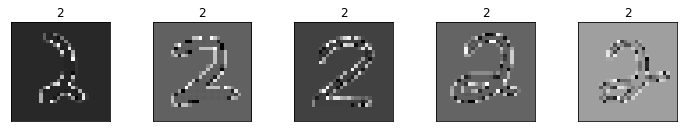

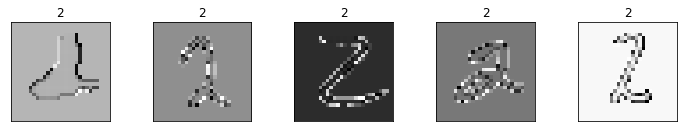

In [46]:
mean=1000
std=500000
add_gaussian_noise(dataset=dataset_train2, client_dict=client_dict, client=0, mean=mean, std=std)
#seeClientData(dataset=dataset_train1, client_dict=iid_dict, client=0)
visualize(dataset_train2, non_iid_dict, 0)

### Experiment4
with noise (mean = 0, std = 50), without adjustment

In [ ]:
model_non_iid4 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid4.cuda()

model_non_iid_trained4 = training(model=model_non_iid4, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode1, validate_on=val_mode1, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained4, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 5
with noise (mean = 0, std = 50), with adjustment, validating on loss


In [ ]:
model_non_iid5 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid5.cuda()

model_non_iid_trained5 = training(model=model_non_iid5, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode2, validate_on=val_mode2, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained5, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

### Experiment 6
 with noise (mean = 0, std = 50), with adjustment, validating on accuracy

In [ ]:
model_non_iid6 = IRIS_NN(input_size, num_hidden_neuron, output_size)
if torch.cuda.is_available():
  model_non_iid6.cuda()

model_non_iid_trained6 = training(model=model_non_iid6, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train2, data_dict=non_iid_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode3, validate_on=val_mode3, plt_title="on non IID Dataset", plt_color="orange")

In [ ]:
testing(model=model_non_iid_trained6, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)

# Experiment -- No Federated Learning

In [51]:
centralized_model = IRIS_NN(input_size, num_hidden_neuron, output_size)
# number of training rounds
rounds = 150
# client fraction
C = 1
# number of clients
K = 1
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = non_iid_partition(dataset_train3, num_clients=K, num_shards=K, report_iid_metric=True) # every client is given only one shard, which is very non_iid 
central_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)

training(model=centralized_model, num_rounds=rounds, batch_size=batch_size, num_classes=num_classes, learning_rate=lr, dataset=dataset_train3, data_dict=central_dict, active_client_fraction=C, num_clients=K, num_epochs=E, criterion=criterion, isClassification=True, weight_mode=weight_mode3, validate_on=val_mode3, plt_title="No FL", plt_color="orange")

-> Variance of mean client data:  7.888609052210118e-31
-> Note: a small value is expected for i.i.d partition and a large value typically indicate the partition is non-iid.
------------------------Training Mode Summary----------------------------
---> Weight mode: adjustment.
---> Validation mode: Validation will be based on validation accuracy.
---> Task type: Classification
-------------------------------------------------------------------------
----------------------------Round Summary--------------------------------
---> Round: 1, Average training loss: 0.06138394185406948
---> Active Clients: [0]
---> Client Training Set Sizes: [48000]
---> Validation losses: [0.08588755130767822]
---> Validation accuracy: [0.9795]
     Validation result: ['11754.0/12000.0']
---> Weights of Local Models: [1.]
-------------------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
visualize(dataset_train3, central_dict, 0)

In [ ]:
testing(model=centralized_model, dataset=dataset_test, bs=batch_size, criterion=criterion, num_classes=num_classes, classes=classes_test, report_accuracy=True)